# **Data load, clean and processing**

audits missing values & duplicates

fixes column names + trims whitespace

imputes nulls (numeric - median, categorical - mode, text - empty string)

removes duplicates

text preprocessing (lowercase, de-punctuate, de-digit, stopword removal)

creates three stemmed columns for each text column: *_porter, *_lancaster, *_snowball

encodes low-cardinality categoricals (one-hot) and scales numeric columns (StandardScaler)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The code is like the setup rules for the data cleaning. It tells the program where to save the cleaned file, how to automatically spot which column has the main text (whether it’s called “text”, “content”, or clean_text), and how to handle category columns. If a column has just a few options or (under 30), the program will turn them into easy-to-use yes/no columns. But if there are too many unique values, it skips that step so the dataset doesn’t get too messy or heavy.

In [ ]:

OUTPUT_PATH = "/content/drive/MyDrive/Ranjitha-DS-Project/combined_corpus_cleaned.csv"

# If not sure of the text column name, the script will auto-detect from this ordered list:
CANDIDATE_TEXT_COLS = ["text", "document", "content", "body", "clean_text"]

# Maximum unique values for a column to be treated as "categorical" and one-hot encoded
MAX_CARDINALITY_FOR_ONEHOT = 30

OneHotEncoder comes from scikit-learn
It’s a tool to turn categorical values (like text labels) into numbers that machine learning models can understand
it also converts each category into a binary column

In [ ]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import re
import unicodedata
from typing import List

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# nltk (stopwords + stemmers)
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

**Porter Stemmer**

Most widely used, moderate aggressiveness.

Example: “running” - “run”, “happiness” - “happi”.

Helps reduce vocabulary size while preserving meaning.

**Lancaster Stemmer**

Very aggressive (often cuts words too short).

Example: “connection” - “connect”, but “universal” - “uni”.

Useful in reducing feature space, but may cause over-stemming.

**Snowball Stemmer**

Improved version of Porter, And it's more consistent.

Example: “studies” - “studi”, “relational” - “relat”.

Strikes a balance between Porter and Lancaster.

Also supports multiple languages (good for your optional multilingual extension).

In [ ]:
# Make sure NLTK resources exist
try:
    _ = stopwords.words("english")
except:
    nltk.download("stopwords")

EN_STOPWORDS = set(stopwords.words("english"))
PORTER = PorterStemmer()
LANCASTER = LancasterStemmer()
SNOWBALL = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# === Functions ===
def normalize_colnames(cols: List[str]) -> List[str]:
    """standardize column names: strip, lowercase, replace spaces/specials with underscores"""
    out = []
    for c in cols:
        c = c.strip()
        c = c.lower()
        c = re.sub(r"[^\w\s]", "_", c)      # replace punctuation with underscore
        c = re.sub(r"\s+", "_", c)          # spaces -> underscore
        c = re.sub(r"_+", "_", c).strip("_")# collapse multiple underscores
        out.append(c)
    return out

In [ ]:
def strip_and_normalize_unicode(s: str) -> str:
    """trim whitespace and normalize weird unicode spacing"""
    if pd.isna(s):
        return s
    s = str(s)
    s = unicodedata.normalize("NFKC", s)
    s = s.strip()
    # collapse internal whitespace to single space
    s = re.sub(r"\s+", " ", s)
    return s

In [ ]:
def basic_text_clean(text: str) -> str:
    """lowercase, remove punctuation/digits, remove stopwords, keep tokens with letters only"""
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # remove punctuation and digits
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\d+", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t.isalpha() and t not in EN_STOPWORDS]
    return " ".join(tokens)

In [ ]:
def stem_text(text: str, algo: str) -> str:
    """apply the requested stemmer to a whitespace-tokenized string"""
    if not text:
        return ""
    tokens = text.split()
    if algo == "porter":
        tokens = [PORTER.stem(t) for t in tokens]
    elif algo == "lancaster":
        tokens = [LANCASTER.stem(t) for t in tokens]
    elif algo == "snowball":
        tokens = [SNOWBALL.stem(t) for t in tokens]
    else:
        raise ValueError("Unknown stemmer: choose from {'porter','lancaster','snowball'}")
    return " ".join(tokens)

In [ ]:
def choose_text_cols(df: pd.DataFrame, candidates: List[str]) -> List[str]:
    """return all existing columns that look like text columns based on provided candidate names
       if none match, heuristically pick 'object' dtype columns with long average length."""
    found = [c for c in candidates if c in df.columns]
    if found:
        return found
    # heuristic: find object columns with avg length > 30 chars (likely text)
    objs = df.select_dtypes(include="object")
    longish = []
    for c in objs.columns:
        try:
            avg_len = objs[c].dropna().astype(str).str.len().mean()
        except Exception:
            avg_len = 0
        if (avg_len or 0) > 30:
            longish.append(c)
    return longish or list(objs.columns)  # fallback: all object columns

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Ranjitha-DS-Project/combined_dataset_New.csv')

In [ ]:
# === 1) INSPECT ===
print(f"Initial shape: {df.shape}")
print("Initial dtypes:\n", df.dtypes)
print("Initial missing per column:\n", df.isna().sum())
print("Initial duplicates:", df.duplicated().sum())

Initial shape: (6584, 4)
Initial dtypes:
 title       object
source      object
category    object
content     object
dtype: object
Initial missing per column:
 title       0
source      0
category    0
content     0
dtype: int64
Initial duplicates: 0


In [ ]:
# === 2) FIX COLUMN NAMES ===
df.columns = normalize_colnames(df.columns.tolist())

In [ ]:
# === 3) TRIM / NORMALIZE STRING CELLS ===
obj_cols = df.select_dtypes(include="object").columns.tolist()
for c in obj_cols:
    df[c] = df[c].map(strip_and_normalize_unicode)

# convert strings that are now empty ("") to NaN
for c in obj_cols:
    df.loc[df[c].astype(str).str.strip() == "", c] = np.nan

In [ ]:
# === 4) HANDLE MISSING VALUES ===
# numeric: median; categorical: mode; text: will be filled with "" after cleaning step
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = [c for c in obj_cols if df[c].nunique(dropna=True) <= MAX_CARDINALITY_FOR_ONEHOT]

# impute numeric
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# impute categoricals (mode)
for c in cat_cols:
    if df[c].isna().any():
        mode_val = df[c].mode(dropna=True)
        mode_val = mode_val.iloc[0] if not mode_val.empty else "unknown"
        df[c] = df[c].fillna(mode_val)

In [ ]:
# === 5) DROP DUPLICATES ===
before = df.shape[0]
df = df.drop_duplicates()
print(f"Removed {before - df.shape[0]} duplicate rows")

Removed 0 duplicate rows


In [ ]:
# === 6) TEXT PREPROCESSING + 3 STEMMERS ===
text_cols = choose_text_cols(df, CANDIDATE_TEXT_COLS)
text_cols = list(dict.fromkeys(text_cols))  # unique, preserve order

if len(text_cols) == 0:
    print("No text columns detected. Skipping text preprocessing.")
else:
    print("Text columns selected for preprocessing:", text_cols)

for c in text_cols:
    # clean base text
    base_clean_col = f"{c}_clean"
    df[base_clean_col] = df[c].fillna("").astype(str).map(basic_text_clean)

    # three stemmed variants
    df[f"{c}_porter"]   = df[base_clean_col].map(lambda s: stem_text(s, "porter"))
    df[f"{c}_lancaster"] = df[base_clean_col].map(lambda s: stem_text(s, "lancaster"))
    df[f"{c}_snowball"]  = df[base_clean_col].map(lambda s: stem_text(s, "snowball"))

Text columns selected for preprocessing: ['content']


In [ ]:
# === 7) ENCODE CATEGORICALS (low-card only, excluding detected text columns & their derived cols) ===
derived_text_cols = set()
for c in text_cols:
    derived_text_cols.update([c, f"{c}_clean", f"{c}_porter", f"{c}_lancaster", f"{c}_snowball"])

safe_cat_cols = [c for c in cat_cols if c not in derived_text_cols]

if safe_cat_cols:
    print("Encoding categoricals:", safe_cat_cols)
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    encoded = ohe.fit_transform(df[safe_cat_cols])
    enc_cols = [f"{safe_cat_cols[i]}__{cat}" for i, cats in enumerate(ohe.categories_) for cat in cats]
    enc_df = pd.DataFrame(encoded, columns=enc_cols, index=df.index)

    #  KEEP the original category column
    df = pd.concat([df, enc_df], axis=1)
else:
    print("No low-cardinality categorical columns to encode.")


Encoding categoricals: ['source', 'category']


In [ ]:
# === 8) SCALE NUMERIC COLUMNS ===
num_cols = df.select_dtypes(include=np.number).columns.tolist()
if num_cols:
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
# === 9) FINAL AUDIT ===
print("Final shape:", df.shape)
print("Final dtypes summary:\n", df.dtypes.value_counts())
print("Remaining missing per column:\n", df.isna().sum().loc[lambda s: s>0].sort_values(ascending=False))

Final shape: (6584, 20)
Final dtypes summary:
 float64    12
object      8
Name: count, dtype: int64
Remaining missing per column:
 Series([], dtype: int64)


In [ ]:
# === 10) SAVE ===
df.to_csv(OUTPUT_PATH, index=False)
print(f" Preprocessing complete. Saved to: {OUTPUT_PATH}")

 Preprocessing complete. Saved to: /content/drive/MyDrive/Ranjitha-DS-Project/combined_corpus_cleaned.csv


In [ ]:
df[["title","source", "category","content", "content_clean","content_porter","content_lancaster","content_snowball"]].head(5)

,title,source,category,content,content_clean,content_porter,content_lancaster,content_snowball
0,Neural network (machine learning),Wikipedia,Machine learning,"In machine learning, a neural network (also ar...",machine learning neural network also artificia...,machin learn neural network also artifici neur...,machin learn neur network also art neur networ...,machin learn neural network also artifici neur...
1,15.ai,Wikipedia,Machine learning,"15.ai, or 15.dev, is a free non-commercial web...",ai dev free non commercial web application res...,ai dev free non commerci web applic research p...,ai dev fre non commerc web apply research proj...,ai dev free non commerci web applic research p...
2,3Blue1Brown,Wikipedia,Machine learning,3Blue1Brown is a math YouTube channel created ...,blue brown math youtube channel created run gr...,blue brown math youtub channel creat run grant...,blu brown math youtub channel cre run grant sa...,blue brown math youtub channel creat run grant...
3,3D reconstruction,Wikipedia,Machine learning,"In computer vision and computer graphics, 3D r...",computer vision computer graphics reconstructi...,comput vision comput graphic reconstruct proce...,comput vis comput graph reconstruct process ca...,comput vision comput graphic reconstruct proce...
4,AAAI Conference on Artificial Intelligence,Wikipedia,Machine learning,The AAAI Conference on Artificial Intelligence...,aaai conference artificial intelligence aaai l...,aaai confer artifici intellig aaai lead intern...,aaa conf art intellig aaa lead intern academ c...,aaai confer artifici intellig aaai lead intern...


# **Manual Labelling**

In [ ]:
import pandas as pd

# Load your cleaned + stemmed dataset
df = pd.read_csv("/content/drive/MyDrive/Ranjitha-DS-Project/combined_corpus_cleaned.csv")

# Ensure a stable row_id exists
if "row_id" not in df.columns:
    df.insert(0, "row_id", range(len(df)))

# Add empty true_label if not exists
if "true_label" not in df.columns:
    df["true_label"] = None

# Save back main dataset with row_id
df.to_csv("/content/drive/MyDrive/Ranjitha-DS-Project/combined_corpus_cleaned.csv", index=False)

# Sample ~700 rows for labelling
subset = df.sample(700, random_state=42).copy()
subset.to_csv("/content/drive/MyDrive/Ranjitha-DS-Project/manual_label_subset.csv", index=False)

print(" Saved 'manual_label_subset.csv' — please open it and fill 'true_label' column manually.")

subset[["title","source", "category","content", "content_clean","content_porter","content_lancaster","content_snowball"]].head(5)

 Saved 'manual_label_subset.csv' — please open it and fill 'true_label' column manually.


,title,source,category,content,content_clean,content_porter,content_lancaster,content_snowball
611,OCLC,Wikipedia,Machine learning,"OCLC, Inc. is an American nonprofit cooperativ...",oclc inc american nonprofit cooperative organi...,oclc inc american nonprofit cooper organ provi...,oclc int am nonprofit coop org provid shar tec...,oclc inc american nonprofit cooper organ provi...
1891,Cerium(IV) oxide,Wikipedia,Climate change,"Cerium(IV) oxide, also known as ceric oxide, c...",cerium iv oxide also known ceric oxide ceric d...,cerium iv oxid also known ceric oxid ceric dio...,cer iv oxid also known cer oxid cer dioxid cer...,cerium iv oxid also known ceric oxid ceric dio...
1419,Hydrofluorocarbon,Wikipedia,Climate change,Hydrofluorocarbons (HFCs) are synthetic organi...,hydrofluorocarbons hfcs synthetic organic comp...,hydrofluorocarbon hfc synthet organ compound c...,hydrofluorocarbon hfcs synthet org compound co...,hydrofluorocarbon hfcs synthet organ compound ...
4414,FIBA Oceania Youth Tournament,Wikipedia,Sports,The FIBA Oceania Youth Tournament was a men's ...,fiba oceania youth tournament men youth basket...,fiba oceania youth tournament men youth basket...,fib ocean you tourna men you basketbal tourna ...,fiba oceania youth tournament men youth basket...
5826,Cavalier,Wikipedia,Politics,The term Cavalier () was first used by Roundhe...,term cavalier first used roundheads term abuse...,term cavali first use roundhead term abus weal...,term cava first us roundhead term abus wealthy...,term cavali first use roundhead term abus weal...


In [ ]:
import pandas as pd

# === 1. Load both raw and cleaned datasets ===
raw_df = pd.read_csv("/content/drive/MyDrive/Ranjitha-DS-Project/combined_dataset_New.csv")  # has original 'category'
clean_df = pd.read_csv("/content/drive/MyDrive/Ranjitha-DS-Project/combined_corpus_cleaned.csv")  # cleaned file

# === 2. Merge original category using index (not row_id) ===
if "category" in raw_df.columns:
    # Ensure both have the same length
    if len(raw_df) == len(clean_df):
        clean_df["original_category"] = raw_df["category"]
        clean_df["true_label"] = clean_df["original_category"].fillna("Unknown")
        print(" true_label successfully filled from 'category' via index alignment")
    else:
        print(f" Row mismatch: raw_df has {len(raw_df)} rows, clean_df has {len(clean_df)} rows")
else:
    print(" 'category' column not found in raw_df — cannot assign true_label")

# === 3. Save final labelled dataset ===
clean_df.to_csv("/content/drive/MyDrive/Ranjitha-DS-Project/combined_corpus_labelled.csv", index=False)
print(" File saved with true_label column")
print("Label counts:\n", clean_df["true_label"].value_counts())
clean_df.head()


 true_label successfully filled from 'category' via index alignment
 File saved with true_label column
Label counts:
 true_label
Sports              2142
Climate change      1768
Politics            1348
Machine learning     997
BBC_Health            95
BBC_Technology        53
BBC_Science           53
Guardian_UK_News      45
BBC_World             44
Guardian_World        39
Name: count, dtype: int64


,row_id,title,source,category,content,content_clean,content_porter,content_lancaster,content_snowball,source__RSS,...,category__BBC_Technology,category__BBC_World,category__Climate change,category__Guardian_UK_News,category__Guardian_World,category__Machine learning,category__Politics,category__Sports,true_label,original_category
0,0,Neural network (machine learning),Wikipedia,Machine learning,"In machine learning, a neural network (also ar...",machine learning neural network also artificia...,machin learn neural network also artifici neur...,machin learn neur network also art neur networ...,machin learn neural network also artifici neur...,-0.229342,...,-0.090084,-0.082023,-0.605896,-0.082957,-0.077193,2.367237,-0.507394,-0.694417,Machine learning,Machine learning
1,1,15.ai,Wikipedia,Machine learning,"15.ai, or 15.dev, is a free non-commercial web...",ai dev free non commercial web application res...,ai dev free non commerci web applic research p...,ai dev fre non commerc web apply research proj...,ai dev free non commerci web applic research p...,-0.229342,...,-0.090084,-0.082023,-0.605896,-0.082957,-0.077193,2.367237,-0.507394,-0.694417,Machine learning,Machine learning
2,2,3Blue1Brown,Wikipedia,Machine learning,3Blue1Brown is a math YouTube channel created ...,blue brown math youtube channel created run gr...,blue brown math youtub channel creat run grant...,blu brown math youtub channel cre run grant sa...,blue brown math youtub channel creat run grant...,-0.229342,...,-0.090084,-0.082023,-0.605896,-0.082957,-0.077193,2.367237,-0.507394,-0.694417,Machine learning,Machine learning
3,3,3D reconstruction,Wikipedia,Machine learning,"In computer vision and computer graphics, 3D r...",computer vision computer graphics reconstructi...,comput vision comput graphic reconstruct proce...,comput vis comput graph reconstruct process ca...,comput vision comput graphic reconstruct proce...,-0.229342,...,-0.090084,-0.082023,-0.605896,-0.082957,-0.077193,2.367237,-0.507394,-0.694417,Machine learning,Machine learning
4,4,AAAI Conference on Artificial Intelligence,Wikipedia,Machine learning,The AAAI Conference on Artificial Intelligence...,aaai conference artificial intelligence aaai l...,aaai confer artifici intellig aaai lead intern...,aaa conf art intellig aaa lead intern academ c...,aaai confer artifici intellig aaai lead intern...,-0.229342,...,-0.090084,-0.082023,-0.605896,-0.082957,-0.077193,2.367237,-0.507394,-0.694417,Machine learning,Machine learning


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_columns = ["content_porter", "content_lancaster", "content_snowball"]

vectorizers, tfidf_matrices = {}, {}

for col in text_columns:
    if col in clean_df.columns:
        print(f"Vectorizing {col} ...")
        vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
        X = vectorizer.fit_transform(clean_df[col].fillna(""))
        vectorizers[col] = vectorizer
        tfidf_matrices[col] = X
        print(f"  Shape: {X.shape}")
    else:
        print(f" Skipping {col} — not found in dataset")

Vectorizing content_porter ...
  Shape: (6584, 5000)
Vectorizing content_lancaster ...
  Shape: (6584, 5000)
Vectorizing content_snowball ...
  Shape: (6584, 5000)


0    Machine learning
1    Machine learning
2    Machine learning
3    Machine learning
4    Machine learning
5    Machine learning
6    Machine learning
7    Machine learning
8    Machine learning
9    Machine learning
Name: true_label, dtype: object
true_label
Sports              2142
Climate change      1768
Politics            1348
Machine learning     997
BBC_Health            95
BBC_Technology        53
BBC_Science           53
Guardian_UK_News      45
BBC_World             44
Guardian_World        39
Name: count, dtype: int64


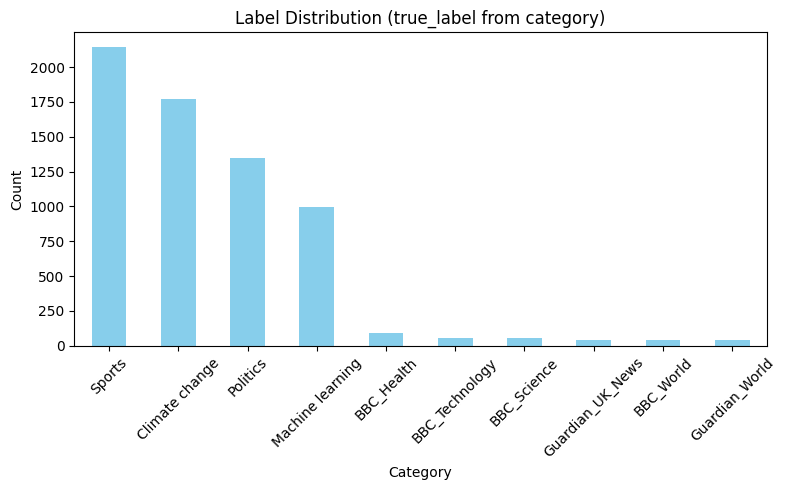

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.manifold import TSNE
import seaborn as sns


#  Check if the column exists first
if "true_label" in clean_df.columns:
    label_counts = clean_df['true_label'].value_counts()

    #  Plot the bar chart
    plt.figure(figsize=(8, 5))
    label_counts.plot(
        kind='bar',
        color="skyblue"
    )
    plt.title("Label Distribution (true_label from category)")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(" Column 'true_label' not found in clean_df")


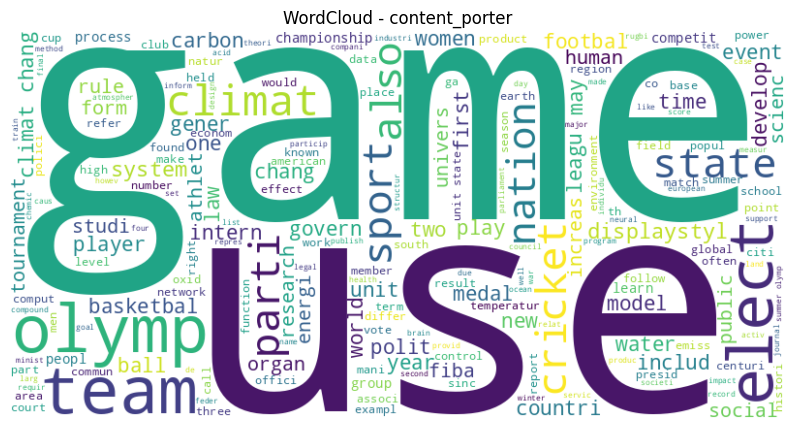

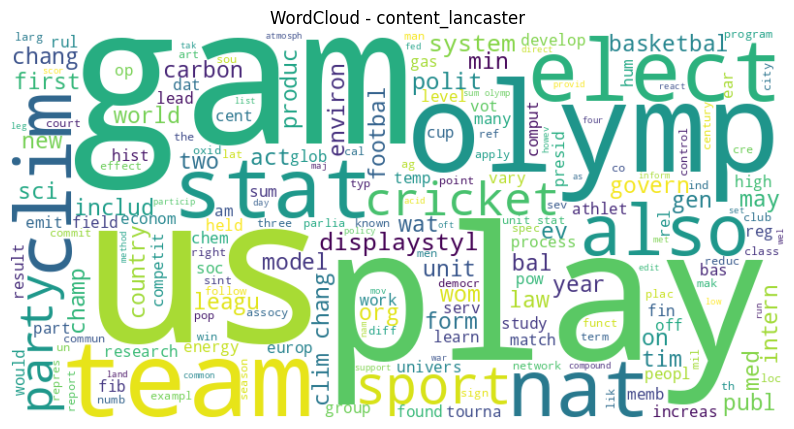

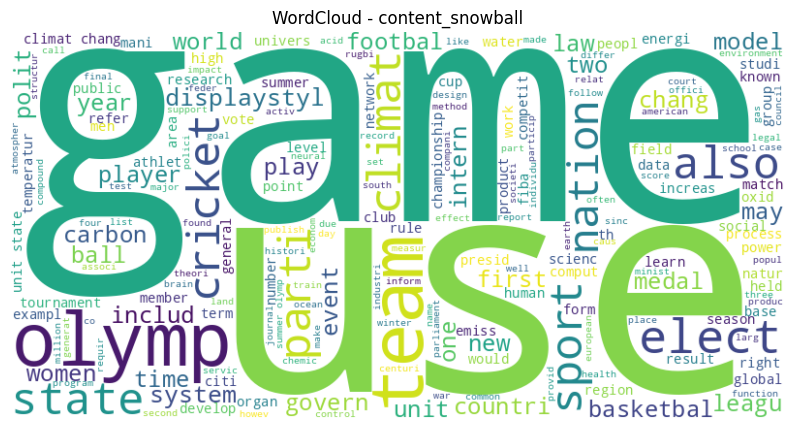

In [ ]:
# 3.2 Wordclouds of TF-IDF features
def plot_wordcloud(vectorizer, X, title):
    tfidf_scores = X.mean(axis=0).A1
    terms = vectorizer.get_feature_names_out()
    freq = dict(zip(terms, tfidf_scores))

    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(freq)
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

for col in text_columns:
    if col in vectorizers:
        plot_wordcloud(vectorizers[col], tfidf_matrices[col], f"WordCloud - {col}")


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


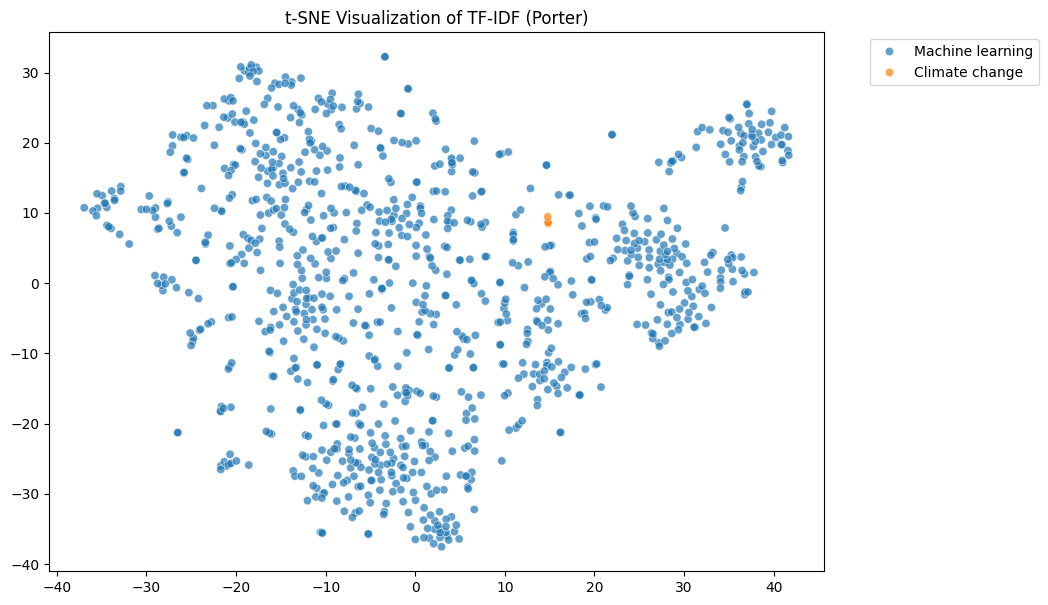

In [ ]:
# 3.3 t-SNE Visualization (Porter version for demo)
if "content_porter" in tfidf_matrices:
    X = tfidf_matrices["content_porter"]
    sample_size = min(1000, X.shape[0])  # limit to 1000 docs for speed
    tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=1000)
    X_embedded = tsne.fit_transform(X[:sample_size].toarray())

    subset = clean_df.iloc[:sample_size]

    plt.figure(figsize=(10,7))
    sns.scatterplot(
        x=X_embedded[:,0],
        y=X_embedded[:,1],
        hue=subset['true_label'],
        palette="tab10",
        alpha=0.7
    )
    plt.title("t-SNE Visualization of TF-IDF (Porter)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()


In [ ]:
# === 4. Clustering ===
from sklearn.cluster import KMeans, AgglomerativeClustering

cluster_results = {}

for col in text_columns:
    if col in tfidf_matrices:
        X = tfidf_matrices[col]

        # KMeans
        kmeans = KMeans(n_clusters=5, random_state=42)
        kmeans_labels = kmeans.fit_predict(X)

        # Agglomerative
        agg = AgglomerativeClustering(n_clusters=5)
        agg_labels = agg.fit_predict(X.toarray())  # needs dense

        cluster_results[col] = {
            "kmeans": kmeans_labels,
            "agglo": agg_labels
        }

        print(f" Clustering done for {col}")


 Clustering done for content_porter
 Clustering done for content_lancaster
 Clustering done for content_snowball


In [ ]:
# === 5. Evaluation ===
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

for col in text_columns:
    if col in tfidf_matrices:
        X = tfidf_matrices[col]
        for algo, labels in cluster_results[col].items():
            # Internal metrics
            sil = silhouette_score(X, labels)
            db = davies_bouldin_score(X.toarray(), labels)

            # External metric (ARI with true_label)
            subset = clean_df.dropna(subset=["true_label"])
            y_true = subset["true_label"]
            y_pred = labels[subset.index]
            ari = adjusted_rand_score(y_true, y_pred)

            print(f"{col} - {algo}: Silhouette={sil:.3f}, DBI={db:.3f}, ARI={ari:.3f}")


content_porter - kmeans: Silhouette=0.030, DBI=5.639, ARI=0.431
content_porter - agglo: Silhouette=0.016, DBI=4.389, ARI=0.149
content_lancaster - kmeans: Silhouette=0.030, DBI=5.560, ARI=0.358
content_lancaster - agglo: Silhouette=0.013, DBI=4.305, ARI=0.088
content_snowball - kmeans: Silhouette=0.030, DBI=5.638, ARI=0.429
content_snowball - agglo: Silhouette=0.017, DBI=4.985, ARI=0.226


k=2: Inertia=6161.09, Silhouette=0.022
k=3: Inertia=6139.20, Silhouette=0.019
k=4: Inertia=6034.24, Silhouette=0.022
k=5: Inertia=5927.69, Silhouette=0.030
k=6: Inertia=5869.62, Silhouette=0.028
k=7: Inertia=5794.90, Silhouette=0.032
k=8: Inertia=5773.13, Silhouette=0.031
k=9: Inertia=5726.29, Silhouette=0.033
k=10: Inertia=5648.12, Silhouette=0.038


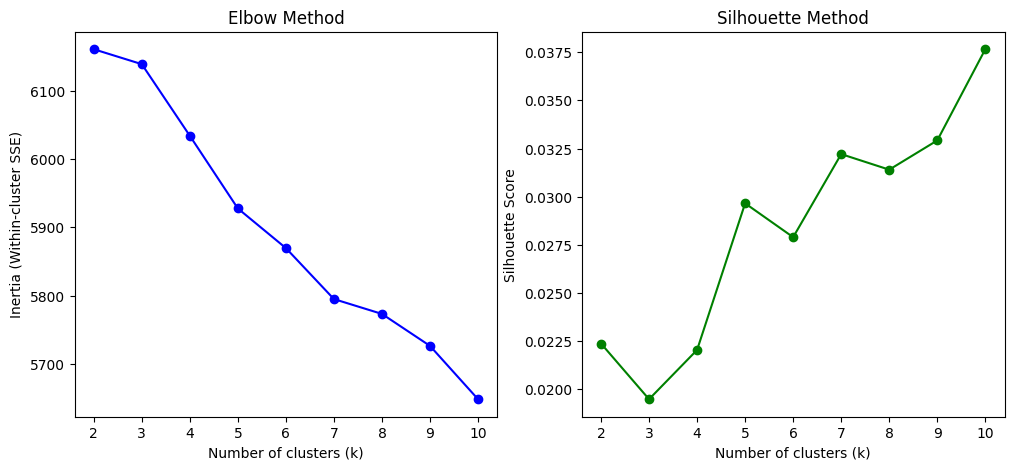

 Best k (by Silhouette): 10
Cluster distribution: 3    2715
0     740
7     680
9     439
5     437
4     437
6     300
1     288
2     280
8     268
Name: count, dtype: int64


In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_best_k(X, k_range=range(2,11)):
    inertia = []
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)

        inertia.append(kmeans.inertia_)
        sil = silhouette_score(X, labels)
        silhouette_scores.append(sil)
        print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil:.3f}")

    # Plot Elbow (Inertia)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(k_range, inertia, 'o-', color="blue")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (Within-cluster SSE)")
    plt.title("Elbow Method")

    # Plot Silhouette
    plt.subplot(1,2,2)
    plt.plot(k_range, silhouette_scores, 'o-', color="green")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Method")

    plt.show()

    # Return the best k by Silhouette score
    best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    print(f" Best k (by Silhouette): {best_k}")
    return best_k

# Example: Use Porter stemmed TF-IDF for testing
X = tfidf_matrices["content_porter"]
best_k = find_best_k(X, range(2,11))

# Now run clustering again with best_k
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X)

print("Cluster distribution:", pd.Series(labels).value_counts())


In [57]:
# === 4. Auto k Selection + Clustering + Evaluation with Summary Table ===
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

def find_best_k(X, k_range=range(2,11), plot=False):
    inertia, silhouette_scores = [], []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
        sil = silhouette_score(X, labels)
        silhouette_scores.append(sil)
    best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    return best_k

# Collect results
results = []

for col in text_columns:
    if col in tfidf_matrices:
        X = tfidf_matrices[col]
        print(f"\n Finding best k for {col} ...")
        best_k = find_best_k(X, range(2,11), plot=True)
        print(f" Best k for {col}: {best_k}")

        # KMeans
        kmeans = KMeans(n_clusters=best_k, random_state=42)
        kmeans_labels = kmeans.fit_predict(X)

        # Agglomerative
        agg = AgglomerativeClustering(n_clusters=best_k)
        agg_labels = agg.fit_predict(X.toarray())

        # External labels
        subset = clean_df.dropna(subset=["true_label"])
        y_true = subset["true_label"]

        # Evaluate both algorithms
        for algo, labels in {"KMeans": kmeans_labels, "Agglomerative": agg_labels}.items():
            sil = silhouette_score(X, labels)
            db = davies_bouldin_score(X.toarray(), labels)
            ari = adjusted_rand_score(y_true, labels[subset.index])

            results.append({
                "Stemmer": col.replace("content_", "").capitalize(),
                "Algorithm": algo,
                "Best_k": best_k,
                "Silhouette": round(sil, 3),
                "DBI": round(db, 3),
                "ARI": round(ari, 3)
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\n Summary of Results:")
results_df



 Finding best k for content_porter ...
 Best k for content_porter: 10

 Finding best k for content_lancaster ...
 Best k for content_lancaster: 10

 Finding best k for content_snowball ...
 Best k for content_snowball: 7

 Summary of Results:


,Stemmer,Algorithm,Best_k,Silhouette,DBI,ARI
0,Porter,KMeans,10,0.038,4.642,0.156
1,Porter,Agglomerative,10,0.026,4.327,0.140
2,Lancaster,KMeans,10,0.035,5.003,0.249
3,Lancaster,Agglomerative,10,0.022,4.949,0.259
4,Snowball,KMeans,7,0.032,4.979,0.219
5,Snowball,Agglomerative,7,0.022,4.886,0.295


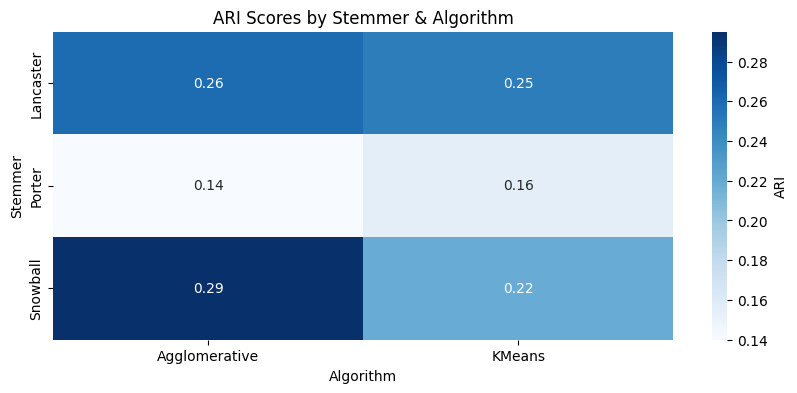

In [ ]:
# table display
import seaborn as sns
plt.figure(figsize=(10,4))
sns.heatmap(
    results_df.pivot(index="Stemmer", columns="Algorithm", values="ARI"),
    annot=True, cmap="Blues", cbar_kws={'label': 'ARI'}
)
plt.title("ARI Scores by Stemmer & Algorithm")
plt.show()
